### Create engines and read data

In [36]:
from util import create_engine
import pandas as pd
from sqlalchemy import select
import matplotlib.pyplot as plt

from experiment import Experiment
from generation import Generation
from individual import Individual
from population import Population

dbengine = create_engine("../big_exp001full.sqlite")

experiments = pd.read_sql(
    select(Experiment.id.label("experiment_id")),
    dbengine,
)["experiment_id"].tolist()

---
Read table names in database for ease of access

In [37]:
table_names = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'",
    dbengine,
)["name"].tolist()

for name in table_names:
    df_exp = pd.read_sql(f'PRAGMA table_info({name});', dbengine)["name"].tolist()
    print(f"{name}:\t", df_exp)

parameters:	 ['evolution_parameters', 'brain_multineat_parameters', 'body_multineat_parameters', 'id']
genotype:	 ['id', 'serialized_body', 'serialized_brain']
population:	 ['id']
experiment:	 ['rng_seed', 'steer', 'parameters_id', 'id']
individual:	 ['population_id', 'population_index', 'genotype_id', 'fitness', 'symmetry', 'xy_positions', 'id']
generation:	 ['experiment_id', 'generation_index', 'population_id', 'id']


---
Read parameters to argmax

In [39]:
params = pd.read_sql(f'select * from parameters', dbengine).sort_values(by=["id"])

ts, steer = [], []
for i, row in params.iterrows():
    i_config = eval(row["evolution_parameters"].replace("false","False").replace("true", "True"))
    ts.append(i_config['tournament_size'])
    steer.append(i_config['steer'])

In [40]:
df_brain_params = []
for i, row in params.iterrows():
    df_row_brain = pd.Series(eval(row["brain_multineat_parameters"].replace("false","False").replace("true", "True")))
    df_brain_params.append(df_row_brain)

df_brain_params = pd.DataFrame(df_brain_params)
# df_brain_params

In [41]:
df_body_params = []
for i, row in params.iterrows():
    df_row_body = pd.Series(eval(row["body_multineat_parameters"].replace("false","False").replace("true", "True")))
    df_body_params.append(df_row_body)

df_body_params = pd.DataFrame(df_body_params)
# df_body_params

In [42]:
dif_df = pd.DataFrame(columns=["exp_id","tournament_size","steer","body_mutation_rate","brain_mutation_rate"])
dif_df["exp_id"] = experiments
dif_df['tournament_size'] = ts
dif_df['steer'] = steer
dif_df["body_mutation_rate"] = df_body_params["OverallMutationRate"]
dif_df["brain_mutation_rate"] = df_brain_params["OverallMutationRate"]
dif_df

,exp_id,tournament_size,steer,body_mutation_rate,brain_mutation_rate
0,1,3,False,0.09,0.09
1,2,6,False,0.09,0.09
2,3,3,True,0.09,0.09
3,4,6,True,0.09,0.09
4,5,3,False,0.15,0.09
5,6,6,False,0.15,0.09
6,7,3,True,0.15,0.09
7,8,6,True,0.15,0.09
8,9,3,False,0.20,0.09
9,10,6,False,0.20,0.09


---
Read fitnesses

In [43]:
# ['population_id', 'population_index', 'genotype_id', 'fitness', 'symmetry', 'xy_positions', 'id']
fitnesses = pd.read_sql(
    select(
        Experiment.id.label("experiment_id"),
        Generation.generation_index,
        Individual.fitness,
        Individual.population_index
    )
    .join_from(Experiment, Generation, Experiment.id == Generation.experiment_id)
    .join_from(Generation, Population, Generation.population_id == Population.id)
    .join_from(Population, Individual, Population.id == Individual.population_id),
    dbengine,
)

---
Merge fitness df and parameter df on experiment id

In [84]:
fitnesses["tournament_size"] = None
fitnesses["steer"] = None
fitnesses["body_mutation_rate"] = None
fitnesses["brain_mutation_rate"] = None

for exp in dif_df["exp_id"].unique():
    fitnesses.loc[fitnesses["experiment_id"]==exp,"tournament_size"] = dif_df[dif_df["exp_id"]==exp]["tournament_size"].tolist()[0]
    fitnesses.loc[fitnesses["experiment_id"]==exp,"steer"] = dif_df[dif_df["exp_id"]==exp]["steer"].tolist()[0]
    fitnesses.loc[fitnesses["experiment_id"]==exp,"body_mutation_rate"] = dif_df[dif_df["exp_id"]==exp]["body_mutation_rate"].tolist()[0]
    fitnesses.loc[fitnesses["experiment_id"]==exp,"brain_mutation_rate"] = dif_df[dif_df["exp_id"]==exp]["brain_mutation_rate"].tolist()[0]


In [85]:
fitnesses

,experiment_id,generation_index,fitness,population_index,tournament_size,steer,body_mutation_rate,brain_mutation_rate
0,1,0,-7.071068,0,3,False,0.09,0.09
1,1,0,-7.086142,1,3,False,0.09,0.09
2,1,0,-7.020524,2,3,False,0.09,0.09
3,1,0,-7.062783,3,3,False,0.09,0.09
4,1,0,-7.152976,4,3,False,0.09,0.09
...,...,...,...,...,...,...,...,...
719995,36,199,-2.048526,95,6,True,0.2,0.2
719996,36,199,-2.054479,96,6,True,0.2,0.2
719997,36,199,-6.610976,97,6,True,0.2,0.2
719998,36,199,-5.579341,98,6,True,0.2,0.2


---
### Plotting
Pre-process fitness database to select for robots/parameters that we want

In [175]:
last_gen_select = 10

max_gen = fitnesses["generation_index"].max()
last_gen_fitnesses = fitnesses[fitnesses["generation_index"]>max_gen-last_gen_select]
# last_gen_fitnesses = last_gen_fitnesses.groupby("experiment_id").mean()

parameters = [
                # "tournament_size", 
                # "steer", 
                "body_mutation_rate", 
                "brain_mutation_rate"
            ]

last_gen_fitnesses = last_gen_fitnesses[ last_gen_fitnesses["tournament_size"] == 6 ]
last_gen_fitnesses = last_gen_fitnesses[ last_gen_fitnesses["steer"] == False ]

In [132]:
# last_gen_fitnesses

---
Plot histograms

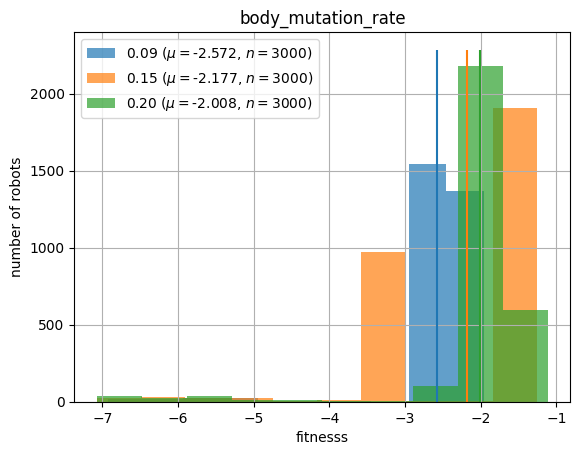

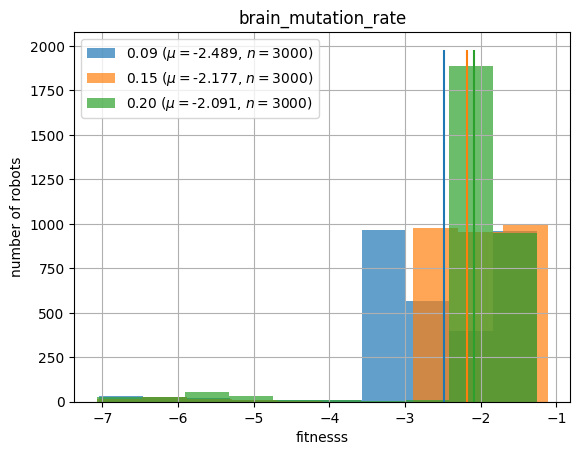

In [167]:
bins = 10

cmap = plt.get_cmap("tab10")
for variable in parameters:
    unique_vals = last_gen_fitnesses[variable].unique()
    this_fitnesses = []
    means = []
    for val in unique_vals:
        temp = last_gen_fitnesses[last_gen_fitnesses[variable]==val]
        temp["fitness"].hist(label=f"{val:0.2f} ($\mu=${temp['fitness'].mean():0.3f}, $n=${len(temp)})", alpha=0.7, bins=bins)
        means.append(temp["fitness"].mean())

    bot,top = plt.gca().get_ylim()
    for i, mean in enumerate(means):
        plt.vlines([mean], bot, top, color=cmap(i))
        
    plt.title(variable)
    plt.xlabel("fitnesss")
    plt.ylabel("number of robots")
    plt.legend()
    plt.show()

---
Plot boxplots

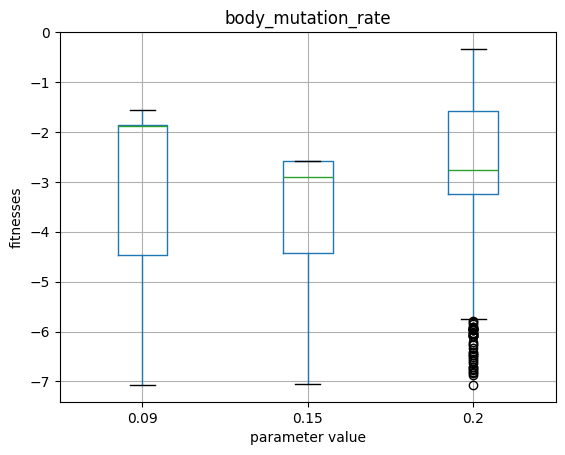

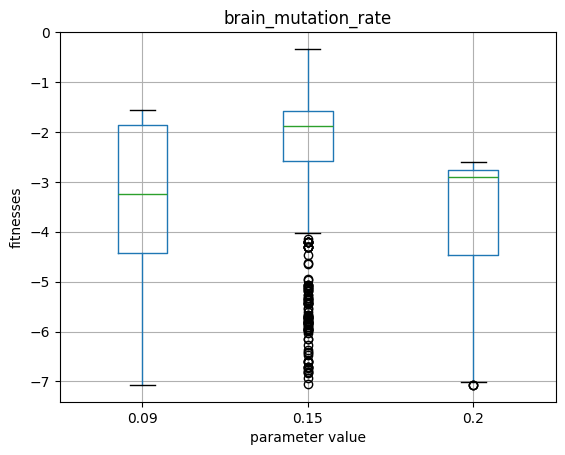

In [176]:
cmap = plt.get_cmap("tab10")
for variable in parameters:
    unique_vals = last_gen_fitnesses[variable].unique()
    this_fitnesses = {}
    for val in unique_vals:
        temp = last_gen_fitnesses[last_gen_fitnesses[variable]==val]        
        this_fitnesses[val] = temp["fitness"].tolist()

    this_fitnesses = pd.DataFrame(this_fitnesses)
    this_fitnesses.boxplot()
    plt.title(variable)
    plt.ylabel("fitnesses")
    plt.xlabel("parameter value")
    plt.show()

In [73]:
# !pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 9.7 MB/s eta 0:00:00:00:0100:01
^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# import plotly.express as px

# fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
#                 "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
#                 "petal_width": "Petal Width", "petal_length": "Petal Length", },
#                              color_continuous_scale=px.colors.diverging.Tealrose,
#                              color_continuous_midpoint=2)
# fig.show()